# <center>ADT Lab 10 (10pts)</center>
### <center> Aaryan Agarwal Fall 2023</center>
## <center>Neo4j</center>

In [1]:
!pip install py2neo
!pip install pandas
!pip install scikit-learn

### Setup Instructions

1. Create a new project in Neo4j desktop
2. Click on Add button
3. Click Local DBMS
4. Set your dbms name and password. (For simplicity keep password as password)
5. Start the db

Your neo4j screen should look something like this-


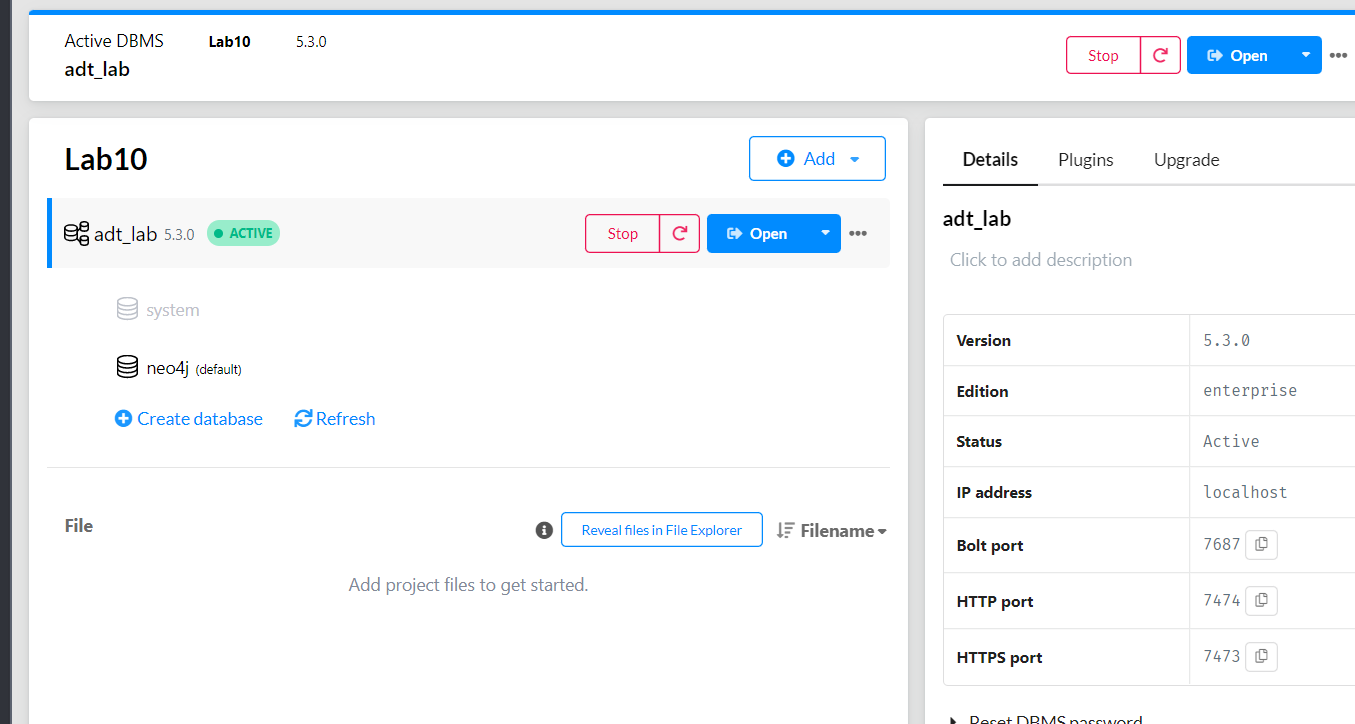


4. Once the database is started run the below cells to populate the newly created neo4j database

In [2]:
import os
import pandas as pd
from py2neo import Graph, Node, Relationship
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# Load the ratings data
ratings = pd.read_csv(os.getcwd()+'/ratings.csv')
ratings=ratings.loc[:10000]
# Load the movie data
movies = pd.read_csv(os.getcwd()+'/movies.csv')
movies=movies[movies['movieId'].isin(ratings['movieId'].unique().tolist())].reset_index()

In [4]:
movies

index  movieId                               title  \
0         0        1                    Toy Story (1995)   
1         1        2                      Jumanji (1995)   
2         2        3             Grumpier Old Men (1995)   
3         3        4            Waiting to Exhale (1995)   
4         4        5  Father of the Bride Part II (1995)   
...     ...      ...                                 ...   
3213   9708   187541                Incredibles 2 (2018)   
3214   9709   187593                   Deadpool 2 (2018)   
3215   9710   187595      Solo: A Star Wars Story (2018)   
3216   9713   188301         Ant-Man and the Wasp (2018)   
3217   9724   190183            The Darkest Minds (2018)   

                                           genres  
0     Adventure|Animation|Children|Comedy|Fantasy  
1                      Adventure|Children|Fantasy  
2                                  Comedy|Romance  
3                            Comedy|Drama|Romance  
4                                          Comedy  
...                                           ...  
3213          Action|Adventure|Animation|Children  
3214                         Action|Comedy|Sci-Fi  
3215             Action|Adventure|Children|Sci-Fi  
3216       Action|Adventure|Comedy|Fantasy|Sci-Fi  
3217                              Sci-Fi|Thriller  

[3218 rows x 4 columns]

In [35]:
# Connect to Neo4j
graph = Graph('bolt://localhost:7687', auth=('neo4j', 'helloworld'))
# graph.run("CREATE CONSTRAINT FOR (u:User) REQUIRE u.userId IS UNIQUE")
# graph.run("CREATE CONSTRAINT FOR (m:Movie) REQUIRE m.movieId IS UNIQUE")

In [6]:
d={}
users_d = {}
movies_d = {}

In [7]:
# Create movie nodes
for index, movie in movies.iterrows():
    node = Node('Movie', movieId=int(movie['movieId']),title=movie['title'])
    graph.merge(node, "Movie", "movieId")
    
    movies_d[movie['movieId']]=node
    d[movie['movieId']]=movie['title']

In [8]:
# Create user nodes
for userId in ratings['userId'].unique():
    node = Node('User', userId=int(userId))
    graph.merge(node, "User", "userId")

    users_d[int(userId)]=node

In [9]:
# Create rating relationships
for index, rating in ratings.iterrows():
    rating_float = float(rating['rating'])
    id_int = int(rating['userId'])
    movie_id_int = int(rating['movieId'])
    
    user_node = users_d[id_int]
    movie_node = movies_d[movie_id_int]
    
    rel = Relationship(user_node, 'RATED', movie_node, rating=rating_float)
    graph.create(rel)

Now check your Neo4j browser. Your data should reflect there-

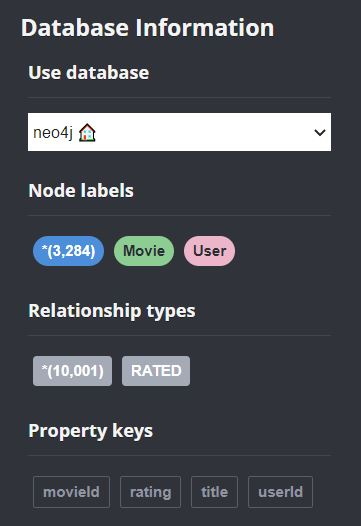

## Create queries for the below questions and run it

### Exmaple Query 1

Find the top-rated movies

In [36]:
query = f"MATCH (m:Movie)<-[r:RATED]-() RETURN m.title, AVG(r.rating) AS avg_rating ORDER BY avg_rating DESC LIMIT 10"

results = graph.run(query)

for record in results:
    print(record)

'Three Colors: Red (Trois couleurs: Rouge) (1994)'	5.0
'Murder in the First (1995)'	5.0
'Canadian Bacon (1995)'	5.0
'Living in Oblivion (1995)'	5.0
'Persuasion (1995)'	5.0
"Antonia's Line (Antonia) (1995)"	5.0
'Home for the Holidays (1995)'	5.0
'Bottle Rocket (1996)'	5.0
'Flirting With Disaster (1996)'	5.0
'Farewell My Concubine (Ba wang bie ji) (1993)'	5.0


This query finds the top-rated movies in the dataset by calculating the average rating for each movie and sorting the results in descending order.

## Query 2
Find the users who have rated the most movies

In [37]:
query = f"MATCH (m:Movie)<-[r:RATED]-(u:User) RETURN u.userId,count(m.title)AS Number_of_ratings ORDER BY Number_of_ratings DESC limit 10"
# print(graph.run(query))
results = graph.run(query)

for record in results:
    print(record)

19	703
28	570
64	517
18	502
57	476
21	443
42	440
45	399
62	366
51	359


This query finds the users who have rated the most movies in the dataset by counting the number of movies each user has rated and sorting the results in descending order.

Hint-

- Use COUNT() aggregate clause

## Expected result-

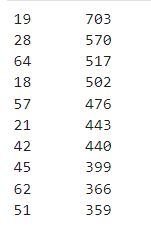

## Query 3
Find movies that were rated the highest by a the user 2

In [51]:
query = f"MATCH (m:Movie)<-[r:RATED]-(u:User) WHERE u.userId=2 RETURN m.title,(r.rating) as rating ORDER BY rating desc limit 10"

results = graph.run(query)

for record in results:
    print(record)

'Mad Max: Fury Road (2015)'	5.0
'The Jinx: The Life and Deaths of Robert Durst (2015)'	5.0
'Warrior (2011)'	5.0
'Inside Job (2010)'	5.0
'Step Brothers (2008)'	5.0
'Wolf of Wall Street, The (2013)'	5.0
'Dark Knight, The (2008)'	4.5
'Town, The (2010)'	4.5
'Inglourious Basterds (2009)'	4.5
'Good Will Hunting (1997)'	4.5


Hint-

- Use MAX() aggregate clause

## Expected result-
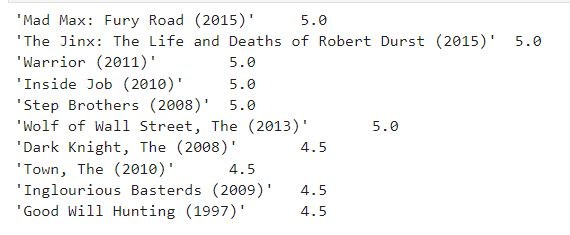

## Query 4
Find the average rating for the moiveId 356

In [54]:
query = f"MATCH (m:Movie)<-[r:RATED]-(u:User) where m.movieId=356 RETURN m.title,avg(r.rating)"

results = graph.run(query)

for record in results:
    print(record)

'Forrest Gump (1994)'	4.1842105263157885


Hint-

- Use AVG() aggregate clause

## Expected result-
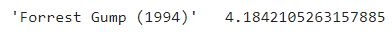

### Run the queries, convert into pdf and submit it

## Optional

In [55]:
# A function to get movie recommendations for a user
def get_movie_recommendations(userId):
    query = f"MATCH (u:User {{userId: {userId}}})-[:RATED]->(m:Movie)<-[:RATED]-(u2:User)-[r2:RATED]->(m2:Movie) WHERE NOT (u)-[:RATED]->(m2) RETURN m2.title AS title, AVG(r2.rating) AS rating ORDER BY rating DESC LIMIT 10"
    results = graph.run(query)

    # Convert the results to a pandas DataFrame
    recommendations = pd.DataFrame(results, columns=['title', 'rating'])

    return recommendations

In [56]:
# Get recommendations for user 3
recommendations = get_movie_recommendations(3)
print(recommendations)

                                             title  rating
0                      Pink Floyd: The Wall (1982)     5.0
1                          Newton Boys, The (1998)     5.0
2                             Wolf Man, The (1941)     5.0
3            All Quiet on the Western Front (1930)     5.0
4  Messenger: The Story of Joan of Arc, The (1999)     5.0
5      Winnie the Pooh and the Blustery Day (1968)     5.0
6                                     Shaft (1971)     5.0
7                        Gulliver's Travels (1939)     5.0
8                                 SLC Punk! (1998)     5.0
9                             Bottle Rocket (1996)     5.0


- The recommendation algorithm above is a simple content-based filtering algorithm, which makes recommendations based on the similarity between items (in this case, movies).
- In a content-based filtering algorithm, the system makes recommendations based on the attributes or features of the items that the user has previously interacted with. In the above example,  the system calculates the cosine similarity between the movie that the user has rated and all other movies in the dataset based on the genres of the movies, and recommends the top N most similar movies.

### Understand the above query and write what you understood. How the recommendation algorithm is working?

In [ ]:
#Here the algorithm is taking the ratings of user 3 and 
#comparing them with other users. If they find a user with
#similar ratings they recommend the highest rated films
#of the other user that the original user has not rated